#ignore 

# Indeed Job Scraper
Purpose of project: 

* Done - create a web scraper that will fetch just the ads specified and none of the "sponsored" junk or recruiter postings.
* scans descriptions with bs4 looking for specific keywords chosen by the user
* Will allow to filter 'data scientist' jobs by the who are looking for Python and R skills specifically but not things like hadoop or scala or spark

# Indeed Job Scraper
What is does: 

* Fetches jobs based on search query, cleans the data, and filters out unwanted jobs that Indeed won't filter for you. Inheretly, this fetches just the ads specified and none of the "sponsored" junk or recruiter postings you often see on Indeed.com.

* Returns a histogram of filtered posts by posting date.
* 
* Will allow to filter 'data scientist' jobs by the who are looking for Python and R skills specifically but not things like hadoop or scala or spark

In [17]:
import ipython_bell
print("done")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'\
        
%bell

done


In [18]:
"""Job Scrape Package."""
import re
from datetime import datetime as dt
from datetime import timedelta as td
from urllib.request import urlopen as urlopen

from bs4 import BeautifulSoup as Soup

from matplotlib.ticker import MaxNLocator

import numpy as np

import pandas as pd
from IPython.display import display

from selenium import webdriver


class JobScrape(object):
    """Job Scrape Object."""

    def __init__(self, query='python+developer', max_days_posted=31,
                 region_city='Seattle', region_state='WA',
                 local_city='Seattle', sort_by='date',
                 job_type='fulltime'):
        """Initialize JobScrape object."""
        self.query = query
        self.region = region_city + ',+' + region_state
        self.sort_by = sort_by
        self.job_type = job_type
        self.max_days_posted = max_days_posted

        self.local_city = local_city
        self.jobs = pd.DataFrame()

        self.results()
        self.clean_results()
        self.filter_results()

        # Report job finished
        print('Job Scrape Finished.')

    def results(self):
        """Get job search results."""
        pd.set_option('max_colwidth', 500)    # to remove column limit

        # Generate base url string.
        url_count = ('http://www.indeed.com/jobs'
                     '?q={}'
                     '&jt={}'
                     '&sort={}'
                     '&l={}'
                     ).format(self.query,
                              self.job_type,
                              self.sort_by,
                              self.region
                              )

        # Make soup from first page.
        url_count_http = urlopen(url_count, timeout=10).read()
        soup_for_count = Soup(url_count_http, 'html.parser')

        # Get number of pages of results and display.
        results_number = soup_for_count.find('div', attrs={
            'id': 'searchCount'}).text
        number_of_results = int(results_number.lstrip().split(
            sep=' ')[3].replace(',', ''))
        print("Scraping " + str(number_of_results) + " results")

        # Loop through the pages, scraping 100 results at a time.
        i = int(number_of_results / 100)
        for page_number in range(i + 1):
            self.parse_page(page_number)

    def parse_page(self, page_number):
        """Parse a single page of 100 job listings."""
        url_results = ('http://www.indeed.com/jobs'
                       '?q={}'
                       '&jt={}'
                       '&sort={}'
                       '&l={}'
                       '&limit=100'
                       '&start={}'
                       ).format(self.query,
                                self.job_type,
                                self.sort_by,
                                self.region,
                                str(100 * page_number)
                                )

        url_results_http = urlopen(url_results, timeout=10).read()
        soup_for_results = Soup(url_results_http, 'html.parser')

        # Store the 100 job listings on the page
        results = soup_for_results.find_all('div', attrs={
            'data-tn-component': 'organicJob'})

        # Parse each job listing and add details to self.jobs DataFrame
        for elem in results:
            self.parse_page_elements(elem)

    def parse_page_elements(self, elem):
        """Add each element to self.jobs."""
        # print(elem)
        # print(elem.find('span', attrs={
        #     'itemprop':'name'}).text.strip())
        # remove this line after testing is finished
        comp_name = elem.find('span', attrs={
            'class': 'company'}).text.strip()
        job_title = elem.find('a', class_=''
                              'turnstileLink').attrs['title']
        # job_title = elem.find('a', attrs={'
        #   data-tn-element': "jobTitle"}).text.strip().capitalize()
        home_url = 'http://www.indeed.com'
        job_link = '%s%s' % (home_url, elem.find('h2', attrs={
            'class': 'jobtitle'}).find('a')['href'])
        # job_link = "https://www.indeed.com" + elem.find('h2',
        #     attrs={"class": "jobtitle"}).find('a')['href']
        job_addr = elem.find('span', attrs={
            'class': 'location'}).text.strip()
        job_posted = elem.find('span', attrs={
            'class': 'date'}).text
        job_id = elem.find('h2', attrs={
            'class': 'jobtitle'})['id']
        days_posted = self.return_days_posted(job_posted)

        # Create Javascript page scraper for use later
        # to parse job descriptions
        # scraper = JobDescScrape()
        # Job Description Parser
        job_desc = None
        # job_desc = scraper.scrape(job_link)

        comp_link_overall = elem.find('span', attrs={
            'itemprop': 'name'})
        # if company link exists, access it. Otherwise, skip.
        if comp_link_overall is not None:
            comp_link_overall = '%s%s' % (
                home_url, comp_link_overall.attrs['href'])
        else:
            comp_link_overall = None

        # add job info to jobs DataFrame
        self.jobs = self.jobs.append({'comp_name': comp_name,
                                      'job_title': job_title,
                                      'job_link': job_link,
                                      'job_posted': job_posted,
                                      'overall_link': comp_link_overall,
                                      'job_location': job_addr,
                                      'job_id': job_id,
                                      'days_posted': days_posted,
                                      'job_desc': job_desc
                                      }, ignore_index=True)

    def clean_results(self):
        """Clean duplicate results"""
        print('Cleaning and formatting')
        self.jobs.drop_duplicates(inplace=True)
        self.jobs['days_posted'] = self.jobs['days_posted'].apply(np.int64)
        self.jobs = self.jobs[['days_posted',
                               'job_title',
                               'job_location',
                               'comp_name',
                               'job_link',
                               'job_desc']]
        # format links into clickable hyperlinks
        # self.jobs['job_link'] =
        # self.jobs['job_link'].apply(lambda x:
        # '<a href="{}">{}</a>'.format(x,x))

    def filter_results(self):
        """Filter unwanted results"""
        print('Filtering')
        self.jobs = self.jobs[
            (self.jobs['days_posted'] <= self.max_days_posted) &
            (self.jobs['job_location'].str.contains(self.local_city, case=False)) &
            (self.jobs['job_title'].str.contains(' ll', case=False) == False) &
            (self.jobs['job_title'].str.contains(' lll', case=False) == False) &
            (self.jobs['job_title'].str.contains(' lv', case=False) == False) &
            (self.jobs['job_title'].str.contains(' v', case=False) == False) &
            (self.jobs['job_title'].str.contains(' II', case=False) == False) &
            (self.jobs['job_title'].str.contains(' III', case=False) == False) &
            (self.jobs['job_title'].str.contains(' IV', case=False) == False) &
            (self.jobs['job_title'].str.contains(' V', case=False) == False) &
            (self.jobs['job_title'].str.contains(' 2', case=False) == False) &
            (self.jobs['job_title'].str.contains(' 3', case=False) == False) &
            (self.jobs['job_title'].str.contains(' 4', case=False) == False) &
            (self.jobs['job_title'].str.contains(' 5', case=False) == False)
        ]

    def histogram(self):
        """Plot histogram of # of posts per day for the past 30 days."""
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        plt.rcParams["axes.labelsize"] = 15
        
        print('Plotting histogram of postings')
        date_max_days_posted, date = self.date_ndays_ago(self.max_days_posted)

        # Make plot
        sns.set(style="white")

        bins = np.arange(0, self.max_days_posted + 1).astype(np.int64)

        ax = sns.countplot(x='days_posted',
                           data=self.jobs,
                           order=bins
                           )
        query_include = ' '.join(self.query.split('+-')[0].split('+'))
        query_exclude = "-" + ' -'.join(self.query.split('+-')[1:])
        title = (query_include.title() + ' Jobs'+ '\n( ' + query_exclude + ' )'+
                 '\n\n  City: ' + self.local_city + '    ' +
                 '\nRegion: ' + ' '.join(self.region.split('+')) +
                 '\n\nFrequency of Posts - %b %d')
        graph_title = (dt.strftime(date,
                                   dt.strftime(date_max_days_posted,
                                               title) + ' to %b %d'))
        xlabel = 'Number of days since posting'
        ylabel = 'Number of postings'
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        ax.set_title(graph_title, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        
        ax.text(0.99, 0.98, 'Total Jobs: '+str(self.jobs.shape[0]),
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize=10)
        
        # Force y-axis to make tick marks at integers (overrides default float)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Make x-axis read from right to left
        ax.invert_xaxis()
        
        if self.max_days_posted > 10:
            plt.setp(ax.get_xticklabels()[1::2], visible=False)
        
        
        # Make ymax just a little bigger than max bin size
        xmin, xmax, ymin, ymax = ax.axis()
        ax.axis(ymax=1.05*ymax)
        
        # Show plot
        plt.show()

    @staticmethod
    def date_ndays_ago(n):
        '''Return date n-days ago and current date.'''
        current_date = dt.now()
        date_n_days_ago = current_date - td(days=n)
        return date_n_days_ago, current_date

    @staticmethod
    def return_days_posted(job_posted):
        """Convert non-numerical 'days posted' into a number."""
        days = job_posted.split()[0]
        if days == 'Just':
            return 0
        elif days == 'Today':
            return 0
        elif days == '30+':
            return 31
        else:
            return days


class JobDescScrape(object):
    """Job Description Object."""

    def __init__(self, link, width=1120, height=550):
        """Initialize PhantomJS driver to load JS redirect links."""
        self.link = link
        self.driver = webdriver.PhantomJS()
        self.driver.set_window_size(width, height)
        self.job_desc = self.scrape_link()

    def scrape_link(self):
        """Scrape description from link."""
        print(self.link)
        self.driver.get(self.link)
        noodles = self.driver.page_source
        soup = Soup(noodles, 'html.parser')

        # Job Description Parser Settings between here and return
        # select tags based on base url
        if "icims.com" in self.link:
            print('on the right track')
            soup_filter = soup.findAll('div')
        else:
            soup_filter = soup.findAll(['p', 'li'])

        # join the array elements (i.e. the array of tags and contents)
        job_description = '\n\n'.join([s.get_text() for s in soup_filter
                                      if len(str(s.get_text())) > 1])

        # Cut junk after add based on base url
        if 'https://tableau' in self.link:
            job_description = job_description.split(
                'Tableau Software is a company on a mission', 1)[0]

        # removes any whitespace between two new lines
        re.sub(r'\n\s*\n', r'\n\n', job_description.strip(), flags=re.M)

        return job_description


if __name__ == '__main__':
    print('docstring')


docstring


Scraping 507 results
Cleaning and formatting
Filtering
Job Scrape Finished.
Plotting histogram of postings


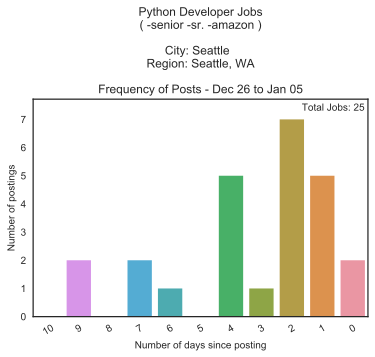

,days_posted,job_title,job_location,comp_name,job_link,job_desc
1,0,"Business Intelligence Engineer, GTM","Seattle, WA",Groupon,http://www.indeed.com/rc/clk?jk=23d00f06052c77fa&fccid=863ad2cc91c92c82,None
2,0,Machine Learning Scientist,"Seattle, WA",demisourced,http://www.indeed.com/company/demisourced/jobs/Machine-Learning-Scientist-60c4a50db36bf48a?fccid=eda7935b076e594d,None
4,1,Software Engineer- Platform,"Seattle, WA",Xinova,http://www.indeed.com/rc/clk?jk=39224f12f17f81e5&fccid=00d972a756ff9194,None
6,1,Software Engineer,"Seattle, WA 98103 (Green Lake - Wallingford area)",Axon,http://www.indeed.com/rc/clk?jk=0489a19452589cce&fccid=72b6c36250909407,None
8,1,Backend Software Engineer (Java),"Seattle, WA",TalentReach,http://www.indeed.com/company/TalentReach/jobs/Backend-Software-Engineer-be562d26753682c7?fccid=fbe153e6bd193174,None
10,1,"Lead Information Management Engineer - Java, AWS, Hadoop","Seattle, WA",DISNEY,http://www.indeed.com/rc/clk?jk=75aa8c0e6bde45da&fccid=4ed80f3a97849f22,None
14,1,Systems Software Engineer - Oracle Cloud Infrastructure,"Seattle, WA",Oracle,http://www.indeed.com/rc/clk?jk=f2e8e226560a2844&fccid=cd22d01053af7669,None
17,2,Software Engineer - Push Marketing,"Seattle, WA",Groupon,http://www.indeed.com/rc/clk?jk=3f64b358b62c566d&fccid=863ad2cc91c92c82,None
18,2,Performance and Capacity Engineer,"Seattle, WA",Facebook,http://www.indeed.com/rc/clk?jk=097cab916a95eec2&fccid=1639254ea84748b5,None


In [19]:
jobsc = JobScrape(query='python+developer+-senior+-sr.+-amazon', 
                  region_city='Seattle', 
                  region_state='WA',
                  local_city='Seattle', 
                  job_type='fulltime',
                  max_days_posted=10,
                  sort_by='date'
                  )
jobsc.histogram()
%bell
output = jobsc.jobs[['days_posted',
                     'job_title',
                     'job_location',
                     'comp_name',
                     'job_desc',
                     'job_link',
                     'job_description'
                    ]]
n=1
c=10
output.iloc[(n-1)*c:n*c-1]


In [30]:
#ignore

jobsc.jobs[['comp_name','job_desc','days_posted']]

,comp_name,job_desc,days_posted
0,Microsoft,None,0
1,Sabey Corporation,None,0
2,Facebook,None,0
3,Microsoft,None,0
4,Microsoft,None,0
5,Tableau,None,1
6,Indeed,None,1
7,Zillow,None,1
8,Google,None,4
9,Google,None,4


In [16]:
#ignore 

output = jobsc.jobs[['comp_name','job_desc']]
n=2
c=10
output.iloc[(n-1)*c:n*c-1]

,comp_name,job_desc
10,Google,None
11,Google,None
12,Oracle,None
13,Epic Games,None
14,Microsoft,None
15,"eShares, Inc.",None
16,Tableau,None
17,Microsoft,None
18,Yubico,None


In [31]:
#ignore 

import pickle
pickle.dump(jobsc.jobs, open("save.p", "wb"))
print('Finished')

Finished


In [32]:
#ignore 

jobsc.jobs.to_pickle("job_scrape.p")

In [7]:
#ignore 
import re
from selenium import webdriver
from bs4 import BeautifulSoup as Soup

#works
url1 = 'http://www.indeed.com/rc/clk?jk=baa0df17576e3c3a&fccid=734cb5a01ee60f80'
#testing
url2 = 'https://us-amazon.icims.com/jobs/492828/data-scientist---tableau-specialist/job?iis=Job+Posting&iisn=Indeed+%28Free+Posting%29&mobile=false&width=1165&height=1200&bga=true&needsRedirect=false&jan1offset=-480&jun1offset=-420'
#testing
url3 = 'http://jobs.jobvite.com/careers/avalara/job/os9h5fwH?__jvst=Job%20Board&__jvsd=Indeed'

class JobDescScraper(object):
    def __init__(self):
        self.driver = webdriver.PhantomJS()
        self.driver.set_window_size(1120, 550)

    def scrape_link(self, link):
        self.driver.get(link)

        soup = Soup(self.driver.page_source,'html.parser')
        
        # select tags based on base url
        if "icims.com" in link:
            print('on the right track')
            soup_filter = soup.findAll('div')
        else:
            soup_filter = soup.findAll(['p','li'])
            
        # join the array elements (i.e. the array of tags and their contents) 
        job_desc = '\n\n'.join([s.get_text() for s in soup_filter if len(str(s.get_text())) > 1])
    
        # Cut junk after add based on base url
        if 'https://tableau' in link:
            job_desc = job_desc.split('Tableau Software is a company on a mission',1)[0]
        
        # removes any whitespace between two new lines
        re.sub(r'\n\s*\n', r'\n\n', job_desc.strip(), flags=re.M)
        
        return job_desc
    
    def scrape(self, link):
        jobs = self.scrape_link(link)
        self.driver.quit()

        return jobs

if __name__ == '__main__':
    scraper = JobDescScraper()
    text = scraper.scrape(url1)
    print(text)
    
    
    


Account central


Apply history


Help center


Job alerts


Job watch list


Recommended jobs


Resumes


Working at Microsoft 


Benefits and perks


Businesses and teams


Mission and culture


Office locations





Benefits and perks



Businesses and teams



Mission and culture



Office locations



Students and graduates 


Apply


Events and webinars


Find your recruiter


International opportunities


Programs





Apply



Events and webinars



Find your recruiter



International opportunities



Programs



Find a job 


Students and graduates


Industry professionals





Students and graduates



Industry professionals



Things to do 


Create a careers account


Explore recommended jobs


Locate events and webinars


Find your recruiter


Review interview tips





Create a careers account



Explore recommended jobs



Locate events and webinars



Find your recruiter



Review interview tips


Working at LinkedIn

Have you ever imagined the world with an infinite 

In [ ]:
#ignore 
        #soup_trim = soup_filter.get_text()

        #job_desc = '\n'.join([s for s in soup_ptrim])

        # Search for different tags on different sites
        #if "icims.com" in link:
        #    soup_filter = soup.findAll('div', { 'class' : 'iCIMS_InfoMsg'})
        #    soup_trim = soup_filter
        #else:
        #    prohibitedWords = ['<p>','</p>','<ul>','</ul>','<li>','</li>']
        #    big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
        #    soup_found = soup.findAll(['p','ul'])
        #    soup_trim = big_regex.sub("<replaced>", 'this message contains Some really Random Words')
        #    
        #    soup_filter = soup.findAll(['p','ul'])
        #    soup_trim = [str(s).replace('<p>', '').replace('</p>', '').replace('<ul>', '').replace('</ul>', '').replace('<il>', '').replace('</il>', '') for s in soup_filter]
        #    
        #    soup_trim = []
        #    for s in soup_filter
        #        soup_trim.append()
        #job_desc = '\n'.join([s for s in soup_ptrim])
        
        
        #the_message = big_regex.sub("<replaced>", 'this message contains Some really Random Words')
        #the_message
        #'this message contains <replaced> really <replaced> <replaced>'
        #soup_ptrim = [str(s).replace('<p>', '').replace('</p>', '').replace('<span>', '').replace('</span>', '') for s in soup_p if 'id=' not in str(s) and 'class=' not in str(s) and 'href=' not in str(s) and '<b>' not in str(s) and 'consideration for employment without regard to' not in str(s) and 'lease try again' not in str(s)]
                
        #soup_ptrim = [str(s).replace('<p>', '').replace('</p>', '')
        #.replace('<span>', '')
        #.replace('</span>', '') 
        #for s in soup_p if 'id=' 
        #not in str(s) and 'class=' 
        #not in str(s) and 'href=' 
        #not in str(s) and '<b>' 
        #not in str(s) and 'consideration for employment without regard to' 
        #not in str(s) and 'lease try again' not in str(s)]


        
        #print(selection)
        
        #for EachPart in selection:
         #   print(EachPart.get_text())
    
        #regex = re.compile('.*job.*')
        #print(regex)
        #soup = Soup(self.driver.page_source)
        #extract = soup.find_all(attrs={"class": regex})
    
        #for item in extract:
            #print(item)
        #.select('div[class*="listing-col-"]')
        #selectionfind_all('div', attrs={'data-tn-component': 'organicJob'})
        #job_desc = '\n'.join([s for s in selection])
        #for EachPart in soup.select('div[class*="listing-col-"]'):
        #print(job_desc)